## CEBoost for Survival Analysis

### Introduction
CEBoost is a method of survival analysis that predicts hazard ratio of coxph using `xgboost` by optimizing the loss function of *Efron Approximation* + *Convex function approximated Concordance Index*.

Here we show you how to use ECBoost model to predict hazard ratio from scratch with the help of `libsurv`.

### Preparation

For all things going well, you would be better to get acquainted with **Survival Analysis**. Otherwise, I suggest you read the [reference](https://lifelines.readthedocs.io/en/latest/Survival%20Analysis%20intro.html).

And it may help a lot if you know a little of the Efron Approximation and Concordance Index.

### Get it started

#### Load datasets

We provide `WHAS` and `METABRIC` datasets for further studies. It can be found in module `libsurv.datasets`.

In [1]:
from libsurv.datasets import load_whas_train
from libsurv.datasets import load_whas_test

data_train = load_whas_train()
data_test = load_whas_test()

In [2]:
print(data_train.columns)

Index(['age', 'gender', 'bmi', 'chf', 'miord', 'e', 't'], dtype='object')


#### Statistics of datasets
Print statistics of survival data. The function `survival_stats` in `libsurv.datasets` provides the tool.

--------------- Survival Data Statistics ---------------
# Rows: 1310
# Columns: 5 + e + t
# Events Ratio: 42.14%
# Min Time: 1
# Max Time: 67



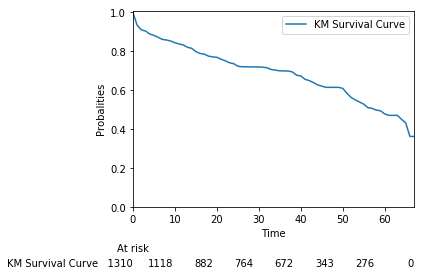

In [3]:
from libsurv.datasets import survival_stats

survival_stats(data_train, t_col="t", e_col="e", plot=True)

--------------- Survival Data Statistics ---------------
# Rows: 328
# Columns: 5 + e + t
# Events Ratio: 42.07%
# Min Time: 1
# Max Time: 67



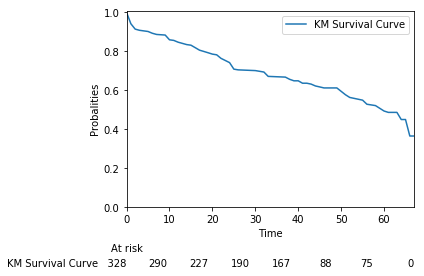

In [4]:
survival_stats(data_test, t_col="t", e_col="e", plot=True)

#### Survival data transfrom

The column of time and status in survival data will be packed into an new column as label in the transformed data.

The transformed survival data contains an new label, where negtive values are considered as right censored, and positive values are considered as event occurrence.

**NOTE**: In `libsurv`, survival data must be transformed via `libsurv.datasets.survival_df`. But for `xgboost` model, the type of data must be `DMatrix`, so we **have two ways to achive this as listed below**.

```python
##############################################################################
# method 1:
from libsurv.datasets import survival_dmat

surv_train = survival_dmat(data_train, t_col="t", e_col="e", label_col="Y")
surv_test = survival_dmat(data_test, t_col="t", e_col="e", label_col="Y")

##############################################################################

##############################################################################
# method 2
from libsurv.datasets import survival_df
from xgboost import DMatrix


data_train = survival_df(data_train, t_col="t", e_col="e", label_col="Y")
data_test = survival_df(data_test, t_col="t", e_col="e", label_col="Y")

x_cols = list(data_train.columns)[:-1]

surv_train = DMatrix(data_train[x_cols], label=data_train['Y'].values)
surv_test = DMatrix(data_test[x_cols], label=data_test['Y'].values)
################################################################################
```

In [5]:
from libsurv.datasets import survival_dmat

# via survival_dmat function
surv_train = survival_dmat(data_train, t_col="t", e_col="e", label_col="Y")
surv_test = survival_dmat(data_test, t_col="t", e_col="e", label_col="Y")

#### Model initialization

Here we start to initialize a CEBoost model.

In [14]:
from libsurv import CEBoost

params = {
    'eta':0.3,
    'max_depth':6, 
    'min_child_weight': 8, 
    'subsample': 0.9,
    'colsample_bytree': 0.5,
    'gamma': 0.20,
    'lambda': 0,
}

model = CEBoost(params, loss_alpha=.0)

#### Model training

Training model and watch the learning curve.

In [15]:
eval_result = model.train(
    surv_train,
    num_rounds=30,
    skip_rounds=10,
    evals=[(surv_train, 'train'), (surv_test, 'test')],
    plot=True
)

[0]	train-rmse:nan	test-rmse:nan	train-ce_loss:nan	test-ce_loss:nan


ValueError: could not convert string to float: '-nan(ind)'

In [8]:
len(model.HR)

1310

In [9]:
model.HR[:200]

array([0.03941168, 0.00259766, 0.01453498, 0.01398217, 0.02844509,
       0.01082141, 0.03552046, 0.02298016, 0.0064206 , 0.01888231,
       0.01874479, 0.01991156, 0.00489693, 0.01948242, 0.02768486,
       0.01063402, 0.01115975, 0.01352432, 0.00561152, 0.01740755,
       0.00482067, 0.05793936, 0.00664855, 0.02090263, 0.00303288,
       0.0262118 , 0.0105258 , 0.0305105 , 0.0187719 , 0.00832773,
       0.00835387, 0.03175467, 0.03175467, 0.04815704, 0.03010577,
       0.00474145, 0.00222698, 0.00126093, 0.00401465, 0.01137693,
       0.01438792, 0.06059422, 0.02440483, 0.03183478, 0.00587075,
       0.01595676, 0.05977313, 0.0480315 , 0.00291237, 0.00236525,
       0.00245944, 0.00929513, 0.02669973, 0.01134664, 0.00395353,
       0.00815681, 0.03524473, 0.0353557 , 0.0037415 , 0.0185359 ,
       0.00908341, 0.02491454, 0.00531129, 0.02217292, 0.01174046,
       0.00245944, 0.01874479, 0.00489693, 0.00236525, 0.02349372,
       0.00241457, 0.00800441, 0.03768902, 0.02491223, 0.02349

#### Prediction and Evaluation

Now we use the trained model to make prediction or evaluate model performance.

Prediction of CEBoost model via:
- `model.predict`: Hazard Ratio of coxph
- `model.predict_survival_function`: survival function transformed from hazard ratio

Prediction of hazard ratio: [0.00608356 0.03051049 0.00696231 0.00835387 0.01953798]


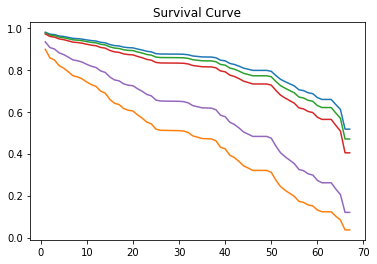

In [10]:
# select the first 5 samples
surv_data_now = surv_test.slice([i for i in range(5)])

# Predict Hazard Ratio
print("Prediction of hazard ratio:", model.predict(surv_data_now, output_margin=False))

# Predict Survival Function
result_survf = model.predict_survival_function(surv_data_now, plot=True)

In [11]:
result_survf

,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,...,58.0,59.0,60.0,61.0,62.0,63.0,64.0,65.0,66.0,67.0
0,0.978598,0.969652,0.967217,0.961088,0.958247,0.954083,0.949493,0.948154,0.945803,0.942047,...,0.690116,0.685958,0.667144,0.658339,0.658339,0.658339,0.633820,0.610432,0.516807,0.516807
1,0.897178,0.856794,0.846054,0.819507,0.807430,0.789989,0.771110,0.765672,0.756198,0.741254,...,0.155653,0.151006,0.131347,0.122880,0.122880,0.122880,0.101581,0.084124,0.036498,0.036498
2,0.975545,0.965346,0.962571,0.955594,0.952362,0.947628,0.942412,0.940891,0.938221,0.933958,...,0.654116,0.649608,0.629258,0.619762,0.619762,0.619762,0.593417,0.568425,0.469807,0.469807
3,0.970729,0.958565,0.955260,0.946958,0.943116,0.937493,0.931305,0.929503,0.926339,0.921290,...,0.600911,0.595945,0.573615,0.563245,0.563245,0.563245,0.534640,0.507738,0.403968,0.403968
4,0.932878,0.905766,0.898479,0.880323,0.871993,0.859883,0.846668,0.842839,0.836146,0.825526,...,0.303866,0.298025,0.272560,0.261175,0.261175,0.261175,0.231202,0.204905,0.120040,0.120040


In [12]:
# evaluate model performance 
print("td-CI on training set:", model.evals(surv_train))
print("td-CI on test set:", model.evals(surv_test))

td-CI on training set: 0.8668491075334208
td-CI on test set: 0.81365257259297


#### save model

In [13]:
model.save_model("CEBoost.model")